In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
cd "/content/drive/My Drive/Colab Notebooks/Predicta/Time_Series"

/content/drive/My Drive/Colab Notebooks/Predicta/Time_Series


In [4]:
!pip install pmdarima
!pip install statsmodels


     -------------------------------------- 614.7/614.7 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 2.8/2.8 MB 4.0 MB/s eta 0:00:00
     ---------------------------------------- 9.9/9.9 MB 4.6 MB/s eta 0:00:00
     -------------------------------------- 233.9/233.9 kB 3.6 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")

# Load data
dataf = pd.read_csv("historical_weather.csv")

# Handle missing values (if any)
dataf['avg_temp_c'] = dataf['avg_temp_c'].fillna(method='ffill') # Forward fill missing temperature values

In [8]:
dataf.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [9]:
# Create a dictionary to store the DataFrames
city_dfs = {}

# Get unique city IDs
unique_cities = dataf['city_id'].unique()

# Create a DataFrame for each city
for city_id in unique_cities:
    # Filter the main DataFrame for the current city
    city_df = dataf[dataf['city_id'] == city_id].copy()

    # Set the 'date' column as the index (optional but often useful for time series analysis)
    city_df.set_index('date', inplace=True)

    # Store the city DataFrame in the dictionary
    city_dfs[city_id] = city_df

In [10]:
city_dfs['C001'].head()

,city_id,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
date,,,,,,,,
2014-01-01,C001,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
2014-01-02,C001,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2014-01-03,C001,7.6,1.9,14.0,NaN,NaN,NaN,5.8
2014-01-04,C001,7.6,3.9,13.3,NaN,NaN,291.0,11.3
2014-01-05,C001,8.6,0.5,16.9,NaN,NaN,NaN,5.0


<Axes: xlabel='date'>

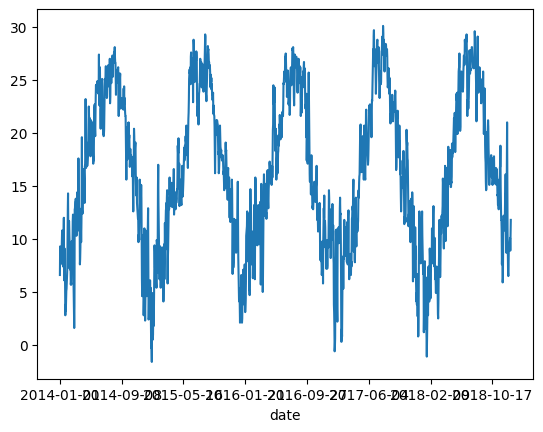

In [11]:
city_dfs['C001']['avg_temp_c'].plot()

In [12]:
df = city_dfs['C001']

In [13]:
df.head()

,city_id,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
date,,,,,,,,
2014-01-01,C001,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
2014-01-02,C001,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2014-01-03,C001,7.6,1.9,14.0,NaN,NaN,NaN,5.8
2014-01-04,C001,7.6,3.9,13.3,NaN,NaN,291.0,11.3
2014-01-05,C001,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [15]:

from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [16]:
adf_test(df['avg_temp_c'])

1. ADF :  -2.435106463096211
2. P-Value :  0.13207198472611542
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1813
5. Critical Values :
	 1% :  -3.433962014811523
	 5% :  -2.86313550332995
	 10% :  -2.5676193929209554


In [17]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [18]:
stepwise_fit = auto_arima(df['avg_temp_c'], suppress_warnings=True)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1826
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -3495.496
Date:                Sun, 23 Jun 2024   AIC                           7002.992
Time:                        22:25:08   BIC                           7036.051
Sample:                    01-01-2014   HQIC                          7015.187
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0434      0.021      2.032      0.042       0.002       0.085
ar.L1          1.8006      0.035     51.964      0.000       1.733       1.868
ar.L2         -1.0456      0.041    -25.757      0.000      -1.125      -0.966
ar.L3          0.2422      0.020     11.867      0.000       0.202       0.282
ma.L1         -0.7883      0.032    -24.513      0.000      -0.851      -0.725
sigma2         2.6883      0.067     40.292      0.000       2.558       2.819
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               310.68
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.35
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
print(df.shape)
train=df.iloc[:-7]
test=df.iloc[-7:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1826, 8)
(1819, 8) (7, 8)
city_id                C001
avg_temp_c              9.0
min_temp_c              3.0
max_temp_c             18.0
precipitation_mm        0.0
snow_depth_mm           NaN
avg_wind_dir_deg      151.0
avg_wind_speed_kmh      4.5
Name: 2018-12-25, dtype: object city_id                C001
avg_temp_c             11.8
min_temp_c              6.0
max_temp_c             18.0
precipitation_mm        1.7
snow_depth_mm           NaN
avg_wind_dir_deg      164.0
avg_wind_speed_kmh      5.7
Name: 2018-12-31, dtype: object


In [21]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['avg_temp_c'],order=(1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             avg_temp_c   No. Observations:                 1819
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -3483.109
Date:                Sun, 23 Jun 2024   AIC                           6982.218
Time:                        22:25:16   BIC                           7026.267
Sample:                    01-01-2014   HQIC                          6998.470
                         - 12-24-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.1996      2.782      5.463      0.000       9.747      20.653
ar.L1          0.9937      0.003    321.904      0.000       0.988       1.000
ma.L1          0.0263      0.019      1.350      0.177      -0.012       0.064
ma.L2         -0.2477      0.021    -11.809      0.000      -0.289      -0.207
ma.L3         -0.1828      0.021     -8.654      0.000      -0.224      -0.141
ma.L4         -0.0729      0.023     -3.223      0.001      -0.117      -0.029
ma.L5         -0.0452      0.020     -2.291      0.022      -0.084      -0.007
sigma2         2.6913      0.067     40.377      0.000       2.561       2.822
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               317.93
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.35
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ConversionError: Failed to convert value(s) to axis units: array([Period('2018-12-24', 'D'), Period('2018-12-25', 'D'),
       Period('2018-12-26', 'D'), Period('2018-12-27', 'D'),
       Period('2018-12-28', 'D'), Period('2018-12-29', 'D'),
       Period('2018-12-30', 'D')], dtype=object)

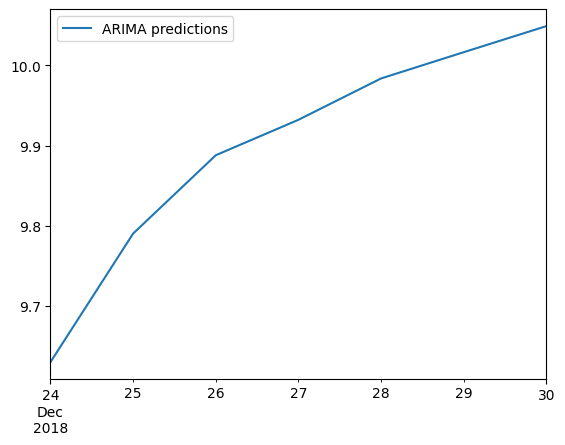

In [23]:
start=len(train)
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2018-12-24',end='2018-12-30')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=index_future_dates
pred.plot(legend=True)
test['avg_temp_c'].plot(legend=True)

In [24]:
test['avg_temp_c'].mean()

9.942857142857141

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['avg_temp_c']))
print(rmse)

0.871834740196869


In [26]:
model2=ARIMA(df['avg_temp_c'],order=(1,0,5))
model2=model2.fit()
df.tail()

,city_id,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
date,,,,,,,,
2018-12-27,C001,9.7,4.0,17.0,0.0,NaN,157.0,6.2
2018-12-28,C001,10.1,5.7,17.0,0.0,NaN,188.0,5.2
2018-12-29,C001,8.9,4.0,17.0,0.0,NaN,164.0,6.2
2018-12-30,C001,10.7,5.0,18.0,0.0,NaN,160.0,8.1
2018-12-31,C001,11.8,6.0,18.0,1.7,NaN,164.0,5.7


In [27]:
index_future_dates=pd.date_range(start='2018-12-30',end='2019-01-05')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+6,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2018-12-30    11.585567
2018-12-31    11.151902
2019-01-01    10.956180
2019-01-02    10.842325
2019-01-03    10.835026
2019-01-04    10.863154
2019-01-05    10.891111
Freq: D, Name: ARIMA Predictions, dtype: float64


<Axes: >

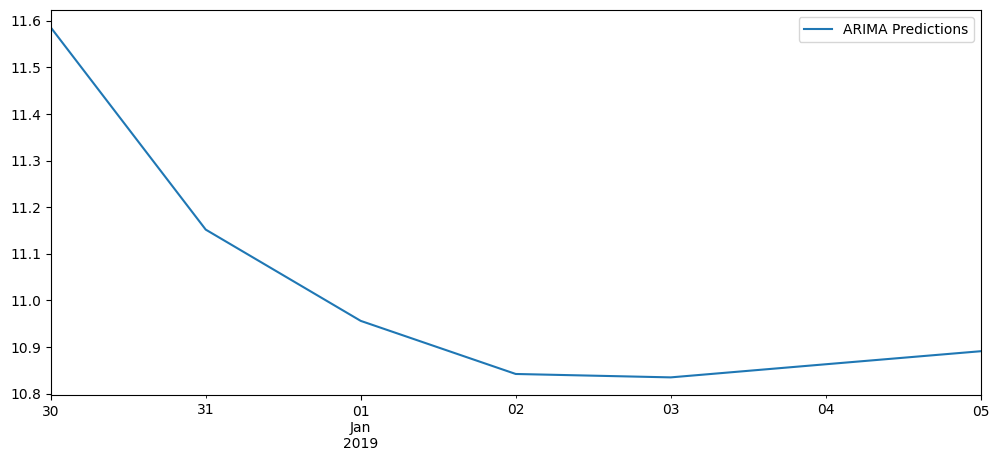

In [28]:
pred.plot(figsize=(12,5),legend=True)

In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import warnings
all_predictions = []
submission_data = []
warnings.filterwarnings("ignore")

# Load data
dataf = pd.read_csv("historical_weather.csv")

# Handle missing values (if any)
dataf['avg_temp_c'] = dataf['avg_temp_c'].fillna(method='ffill')  

# Create a dictionary to store the DataFrames
city_dfs = {}

# Get unique city IDs
unique_cities = dataf['city_id'].unique()

# Function to perform ADF test (you already had this, just organizing)
def adf_test(dataset):
    # ... (same as your code)

# Lists to store results


# Iterate through each city
for city_id in unique_cities:
    print(f"Processing city: {city_id}")  # Progress indicator
    df = dataf[dataf['city_id'] == city_id].copy()
    df.set_index('date', inplace=True)

    # ADF Test (optional, but good practice)
    adf_test(df['avg_temp_c'])

    # Auto ARIMA to find optimal parameters (optional, replace if you prefer fixed)
    stepwise_fit = auto_arima(df['avg_temp_c'], suppress_warnings=True)

    # Train the ARIMA model
    model = ARIMA(df['avg_temp_c'], order=stepwise_fit.order)  # Use auto_arima's order
    model = model.fit()

    # Predict for the first week of 2019
    index_future_dates = pd.date_range(start='2019-01-01', end='2019-01-07')
    pred = model.predict(start=len(df), end=len(df) + 6, typ='levels')
    pred.index = index_future_dates

    # Store predictions and create submission format
    all_predictions.append(pred)
    for date, temp in pred.items():
        submission_data.append({
            "submission_ID": len(submission_data) + 1, 
            "city_id": city_id,
            "date": date,
            "avg_temp_c": temp
        })

# Create final DataFrames for submission
submission_df = pd.DataFrame(submission_data)
all_predictions_df = pd.concat(all_predictions, axis=1)
all_predictions_df.columns = unique_cities  # Set city IDs as column names

# Save to CSV files
submission_df[['submission_ID', 'avg_temp_c']].to_csv("sample_submission.csv", index=False)
submission_df.to_csv("submission_key.csv", index=False)  # For reference
all_predictions_df.to_csv("all_city_predictions.csv")  # For your analysis


IndentationError: expected an indented block after function definition on line 24 (3986202770.py, line 31)